# CNTK 200: A Guided Tour

This tutorial exposes many advanced features of CNTK and is aimed towards people who have had some previous exposure to deep learning and/or other deep learning toolkits. If you are a complete beginner we suggest you start with the CNTK 101 Tutorial and come here after you have covered most of the 100 series.

Welcome to CNTK! Deep neural networks are redefining how computer programs are created. In addition to imperative, functional, declarative programming, we now have differentiable programming which effectively 'learns' programs from data.

CNTK is the prime tool that Microsoft product groups use to create deep models for a whole range of products,
from speech recognition and machine translation via various image-classification services
to Bing search ranking.

This tutorial is a guided tour of CNTK. It is primarily meant for users that are new to CNTK but have some experience with deep neural networks.
The focus will be on how the basic steps of deep learning are done in CNTK,
which we will show predominantly by example.
This tour is not a complete API description. Instead, we refer the reader to the documentation
and task-specific tutorials for more detailed information.

To train a deep model, you will need to define your model structure, prepare your data so that it can be fed to CNTK, train the model and evaluate its accuracy, and deploy it.

This guided tour is organized as follows:

 * Defining your **model structure**
    * The CNTK programming model: Networks as Function Objects
    * CNTK's Data Model: Tensors and Sequences of Tensors
    * Your First CNTK Network: Logistic Regression
    * Your second CNTK Network: MNIST Digit Recognition
    * The Graph API: MNIST Digit Recognition Once More
 * Feeding your **data**
    * Small data sets that fit into memory: numpy/scipy arrays/
    * Large data sets: `MinibatchSource` class
    * Spoon-feeding data: your own minibatch loop
 * **Training**
    * Distributed Training
    * Logging
    * Checkpointing
    * Cross-validation based training control
    * Final evaluation
 * **Deploying** the model
    * From Python
    * From C++ and C#
    * From your own web service
    * Via an Azure web service
 * Conclusion

To run this tutorial, you will need CNTK v2 and ideally a CUDA-capable GPU (deep learning is no fun without GPUs).

We start with some imports we will use in the rest of the tutorial.

In [1]:
from __future__ import print_function
import cntk
import numpy as np
import scipy.sparse
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
cntk.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable
from IPython.display import Image
import matplotlib.pyplot
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = (40,40)

## Defining Your Model Structure

So let us dive right in. Below we will introduce CNTK's data model and CNTK's programming model--*networks are function objects*  (i.e. a network can be called like a function, and it also holds some state, the weights, or parameters, that get adjusted during learning). We will put that into action for logistic regression and MNIST digit recognition,
using CNTK's Functional API. Lastly, CNTK also has a lower-level graph API. We will replicate one example with it.

### The CNTK Programming Model: Networks are Function Objects

In CNTK, a neural network is a function object.
On one hand, a neural network in CNTK is just a function that you can call
to apply it to data.
On the other hand, a neural network contains learnable parameters
that can be accessed like object members.
Complicated networks can be composed as hierarchies of simpler ones, which,
for example, represent layers.
The function-object approach is similar to [Keras](https://keras.io), [Chainer](http://chainer.org), [Dynet](https://github.com/clab/dynet), [Pytorch](http://pytorch.org/), and [Sonnet](https://github.com/deepmind/sonnet).

The following illustrates the function-object approach with **pseudo-code**, using the example
of a fully-connected layer (called `Dense` in CNTK):

In [2]:
# *Conceptual* numpy implementation of CNTK's Dense layer (simplified, e.g. no back-prop)
def Dense(out_dim, activation):
    # create the learnable parameters
    b = np.zeros(out_dim)
    W = np.ndarray((0,out_dim)) # input dimension is unknown
    # define the function itself
    def dense(x):
        if len(W) == 0: # first call: reshape and initialize W
            W.resize((x.shape[-1], W.shape[-1]), refcheck=False)
            W[:] = np.random.randn(*W.shape) * 0.05
        return activation(x.dot(W) + b)
    # return as function object: can be called & holds parameters as members
    dense.W = W
    dense.b = b
    return dense

d = Dense(5, np.tanh)    # create the function object
y = d(np.array([1, 2]))  # apply it like a function
W = d.W                  # access member like an object
print('W =', d.W)
print('y =', y)

W = [[-0.04255305 -0.00306212 -0.06292971 -0.00450488 -0.0248121 ]
 [-0.03296314  0.00635099 -0.1045115  -0.00292458  0.0368143 ]]
y = [-0.1080558   0.00963955 -0.26544091 -0.01035366  0.04877776]


Again, this is only **pseudo-code**. In reality, CNTK function objects are not backed by numpy arrays.
Rather, they are represented internally as graph structures in C++ that encode the computation, similar to other deep learning toolkits. In fact the line

```python
d = Dense(5, np.tanh)
``` 

is just construsting a graph, while the line 

```python
y = d(np.array([1, 2]))
``` 

is feeding data to the graph execution engine.

This graph structure is wrapped in the Python class `Function` that exposes the necessary interface so that other Python functions can call it and access its members (such as `W` and `b`).

The function object is CNTK's single abstraction used to represent different operations, which
are only distinguished by convention:

 * **basic operations** without learnable parameters (e.g. `+`, `*`, `sigmoid()`...)
 * **layers** (`Dense()`, `Embedding()`, `Convolution()`...). Layers map one input to one output and may have learnable parameters attached to them.
 * **recurrent step functions** (`LSTM()`, `GRU()`, `RNNStep()`). Step functions map a previous state and a new input to a new state.
 * **loss and metric** functions (`cross_entropy_with_softmax()`, `binary_cross_entropy()`, `squared_error()`, `classification_error()`...).
   In CNTK, losses and metric are not particularly special, they are just functions. The only difference is that while a CNTK function can have one or multiple outputs, a loss and metric must have a single output. Note that a loss does not have to output a scalar value: If the output of a loss is not scalar, CNTK will automatically define the loss as the sum of the outputs. This behavior can be overriden by explicitly performing a reduction operation by yourself.   
 * **models**. Models are defined by the user. A model maps features to predictions or scores, and is what gets deployed in the end.
 * **criterion function**. The criterion function maps (features, labels) to a loss and optionally a metric.
   The Trainer optimizes the loss by SGD, and logs the metric. The metric may be non-differentiable, but the loss must be differentiable.

Higher-order layers compose objects into more complex ones, including:

 * layer **stacking** (`Sequential()`, `For()`)
 * **recurrence** (`Recurrence()`, `Fold()`, `UnfoldFrom()`, ...)

Networks are commonly defined by using existing CNTK functions (such as
specific types of neural-network layers)
and composing them using `Sequential()`.
In addition, users can write their own functions
as arbitrary Python expressions, as long as those consist of CNTK operations
over CNTK data types.
Python expressions get converted into the internal representation by wrapping them in a call to
`Function()`. Expressions can be written as multi-line functions through decorator syntax (`@Function`).

Even if an operation cannot be expressed by combining CNTK's primitives, there are mechanisms
for [extending CNTK](https://www.cntk.ai/pythondocs/extend.html) by writing your own "layer"
in Python (or in C++). This is advanced functionality, that you shouldn't worry about now,
but it's good to know about it in case you ever need it.

Finally, CNTK function objects enable easy parameter sharing. If you call the same
function object at multiple places, all invocations will naturally share the same learnable parameters.
To avoid sharing parameters, you simply create two different function objects.

In summary, the function object is CNTK's single abstraction for conveniently defining
simple and complex models, parameter sharing, and training objectives.

It is also possible to define CNTK networks directly in terms of its underlying graph operations, similar to many other toolkits. And you can freely *mix and match* between the two styles of defining your neural network. This is discussed further below.

### CNTK's Data model: Sequences of Tensors

CNTK can operate on two types of data:

 * **tensors** (that is, N-dimensional arrays), dense or sparse
 * **sequences** of tensors

The distinction is that the shape of a tensor is static during operation,
while the length of a sequence depends on data.
In CNTK we use axes to mean the same thing as dimensions for numpy arrays, 
i.e. a tensor of shape (7,10,6) has three *axes*.
Tensors have *static axes*, while a sequence has an additional *dynamic axis*.
A dynamic axis, is therefore a variable length axis.

Categorical data is represented as sparse one-hot tensors 
(i.e. having all elements 0 except a single 1 at the position of the category it encodes).
This allows to write embeddings and loss functions in a unified fashion as matrix products.

Printing a CNTK function will give you an output similar to the following format:

*Operation*(Sequence[Tensor[*shape*]], *other arguments*) -> Tensor[*shape*]

When the *Operation* is `Composite` the function is representing the whole graph underneath it and what's shown is just the last operation. This graph has a certain number of inputs that expect particular types of inputs. When you print a function you will note **the absence of a batch dimension**. CNTK hides batching from the user. We want users to think in tensors and sequences, and leave mini-batching to CNTK. Unlike other toolkits, CNTK can also automatically batch sequences with different lengths into one minibatch, and handles all necessary padding and packing. Workarounds like 'bucketing' are not needed. The reason we are separatring the dynamic axes (batch and sequence) from the static axes is because there are only very few operations that affect these axes. By default you want to do something to every example in the batch and every element of a sequence. Only few special operations (such as recurrence, or batch normalization), need to deal with these axes.

### Your First CNTK Network: Simple Logistic Regression

Let us put all of this in action for a very simple example of logistic regression.
For this example, we create a synthetic data set of 2-dimensional normal-distributed 
data points, which should be classified into belonging to one of two classes.
Note that CNTK expects the labels as one-hot encoded.

In [3]:
input_dim_lr = 2    # classify 2-dimensional data
num_classes_lr = 2  # into one of two classes

# This example uses synthetic data from normal distributions,
# which we generate in the following.
#  X_lr[corpus_size,input_dim] - input data
#  Y_lr[corpus_size]           - labels (0 or 1), one-hot-encoded
np.random.seed(0)
def generate_synthetic_data(N):
    Y = np.random.randint(size=N, low=0, high=num_classes_lr)  # labels
    X = (np.random.randn(N, input_dim_lr)+3) * (Y[:,None]+1)   # data
    # Our model expects float32 features, and cross-entropy
    # expects one-hot encoded labels.
    Y = scipy.sparse.csr_matrix((np.ones(N,np.float32), (range(N), Y)), shape=(N, num_classes_lr))
    X = X.astype(np.float32)
    return X, Y
X_train_lr, Y_train_lr = generate_synthetic_data(20000)
X_test_lr,  Y_test_lr  = generate_synthetic_data(1024)
print('data =\n', X_train_lr[:4])
print('labels =\n', Y_train_lr[:4].todense())

data =
 [[ 2.2741797   3.56347561]
 [ 5.12873602  5.79089499]
 [ 1.3574543   5.5718112 ]
 [ 3.54340553  2.46254587]]
labels =
 [[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


We now define the model function. The model function maps input data to predictions.
It is the final product of the training process.
In this example, we use the simplest of all models: logistic regression.

In [4]:
model_lr_factory = cntk.layers.Dense(num_classes_lr, activation=None)
x = cntk.input_variable(input_dim_lr)
y = cntk.input_variable(num_classes_lr, is_sparse=True)
model_lr = model_lr_factory(x)

Next, we define the criterion function. The criterion function is
the harness via which the trainer uses to optimize the model:
It maps (input vectors, labels) to (loss, metric).
The loss is used for the SGD updates. We choose cross entropy.
Specifically, `cross_entropy_with_softmax()` first applies
the `softmax()` function to the network's output, as
cross entropy expects probabilities.
We do not include `softmax()` in the model function itself, because
it is not necessary for using the model.
As the metric, we count classification errors (this metric is not differentiable).

We define criterion function as Python code and convert it to a `Function` object.
A single expression can be written as `Function(lambda x, y: `*expression of x and y*`)`,
similar to Keras' `Lambda()`.
To avoid evaluating the model twice, we use a Python function definition
with decorator syntax. This is also a good time to tell CNTK about the
data types of our inputs, which is done via the decorator `@Function`:

In [5]:
@cntk.Function
def criterion_lr_factory(data, label_one_hot):
    z = model_lr_factory(data)  # apply model. Computes a non-normalized log probability for every output class.
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot) # applies softmax to z under the hood
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric
criterion_lr = criterion_lr_factory(x, y)
print('criterion_lr:', criterion_lr)

criterion_lr: Composite(Tensor[2], SparseTensor[2]) -> Tuple[Tensor[1], Tensor[1]]


The decorator will 'compile' the Python function into CNTK's internal graph representation.
Thus, the resulting `criterion` not a Python function but a CNTK `Function` object.

We are now ready to train our model.

In [6]:
learner = cntk.sgd(model_lr.parameters,
                   cntk.learning_parameter_schedule(0.1))
progress_writer = cntk.logging.ProgressPrinter(0)

criterion_lr.train((X_train_lr, Y_train_lr), parameter_learners=[learner],
                   callbacks=[progress_writer])

print(model_lr.W.value) # peek at updated W

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per minibatch: 0.1
     3.58       3.58      0.562      0.562            32
     1.61      0.629      0.458      0.406            96
      1.1      0.715      0.464      0.469           224
     0.88      0.688      0.454      0.445           480
    0.734      0.598      0.427      0.402           992
    0.637      0.543      0.351      0.277          2016
    0.541      0.447      0.257      0.165          4064
     0.45      0.359      0.186      0.115          8160
    0.366      0.284      0.137     0.0876         16352
[[-1.25055373 -0.53687984]
 [-0.99188507 -0.30086043]]


The `learner` is the object that actually performs the model update. Alternative learners include `momentum_sgd()` and `adam()`. The `progress_writer` is a stock logging callback that prints the output you see above, and can be replaced by your own
or the stock `TensorBoardProgressWriter` to visualize training progress using TensorBoard.

The `train()` function is feeding our data `(X_train_lr, Y_train_lr)` minibatch by minibatch to the model and updates it, where the data is a tuple in the same order as the arguments of `criterion_lr()`.

Let us test how we are doing on our test set (this will also run minibatch by minibatch).

In [7]:
test_metric_lr = criterion_lr.test((X_test_lr, Y_test_lr),
                                   callbacks=[progress_writer]).metric

Finished Evaluation [1]: Minibatch[1-32]: metric = 8.11% * 1024;


And lastly, let us run a few samples through our model and see how it is doing.
Oops, `criterion` knew the input types, but `model_lr` does not, so we tell it.

In [8]:
model_lr = model_lr_factory(x)
print('model_lr:', model_lr)

model_lr: Dense(Tensor[2]) -> Tensor[2]


Now we can call it like any Python function:

In [9]:
z = model_lr(X_test_lr[:20])
print("Label    :", [label.todense().argmax() for label in Y_test_lr[:20]])
print("Predicted:", [z[i,:].argmax() for i in range(len(z))])

Label    : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Predicted: [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


### Your Second CNTK Network: MNIST Digit Recognition

Let us do the same thing as above on an actual task--the MNIST benchmark, which is sort of the "hello world" of deep learning.
The MNIST task is to recognize scans of hand-written digits. We first download and prepare the data.
In Tutorial 103C you can find a more succinct way to write the entire MNIST digit recognition workflow using convenience functionality built into CNTK

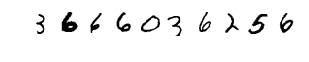

In [10]:
input_shape_mn = (28, 28)  # MNIST digits are 28 x 28
num_classes_mn = 10        # classify as one of 10 digits

# Fetch the MNIST data. Best done with scikit-learn.
try:
    from sklearn import datasets, utils
    mnist = datasets.fetch_mldata("MNIST original")
    X, Y = mnist.data / 255.0, mnist.target
    X_train_mn, X_test_mn = X[:60000].reshape((-1,28,28)), X[60000:].reshape((-1,28,28))
    Y_train_mn, Y_test_mn = Y[:60000].astype(int), Y[60000:].astype(int)
except: # workaround if scikit-learn is not present
    import requests, io, gzip
    X_train_mn, X_test_mn = (np.fromstring(gzip.GzipFile(fileobj=io.BytesIO(requests.get('http://yann.lecun.com/exdb/mnist/' + name + '-images-idx3-ubyte.gz').content)).read()[16:], dtype=np.uint8).reshape((-1,28,28)).astype(np.float32) / 255.0 for name in ('train', 't10k'))
    Y_train_mn, Y_test_mn = (np.fromstring(gzip.GzipFile(fileobj=io.BytesIO(requests.get('http://yann.lecun.com/exdb/mnist/' + name + '-labels-idx1-ubyte.gz').content)).read()[8:], dtype=np.uint8).astype(int) for name in ('train', 't10k'))

# Shuffle the training data.
np.random.seed(0) # always use the same reordering, for reproducability
idx = np.random.permutation(len(X_train_mn))
X_train_mn, Y_train_mn = X_train_mn[idx], Y_train_mn[idx]

# Further split off a cross-validation set
X_train_mn, X_cv_mn = X_train_mn[:54000], X_train_mn[54000:]
Y_train_mn, Y_cv_mn = Y_train_mn[:54000], Y_train_mn[54000:]

# Our model expects float32 features, and cross-entropy expects one-hot encoded labels.
Y_train_mn, Y_cv_mn, Y_test_mn = (scipy.sparse.csr_matrix((np.ones(len(Y),np.float32), (range(len(Y)), Y)), shape=(len(Y), 10)) for Y in (Y_train_mn, Y_cv_mn, Y_test_mn))
X_train_mn, X_cv_mn, X_test_mn = (X.astype(np.float32) for X in (X_train_mn, X_cv_mn, X_test_mn))

# Have a peek.
matplotlib.pyplot.rcParams['figure.figsize'] = (5, 0.5)
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(np.concatenate(X_train_mn[0:10], axis=1), cmap="gray_r")

Let's define the CNTK model function to map (28x28)-dimensional images to a 10-dimensional score vector. We wrap that in a function so that later in this tutorial we can easily recreate it.
For those familiar with Tutorial 103D, you will learn how to use the layers library to compose larger networks, train and test them in a simple way.

In [11]:
def create_model_mn_factory():
    with cntk.layers.default_options(activation=cntk.ops.relu, pad=False):
        return cntk.layers.Sequential([
            cntk.layers.Convolution2D((5,5), num_filters=32, reduction_rank=0, pad=True), # reduction_rank=0 for B&W images
            cntk.layers.MaxPooling((3,3), strides=(2,2)),
            cntk.layers.Convolution2D((3,3), num_filters=48),
            cntk.layers.MaxPooling((3,3), strides=(2,2)),
            cntk.layers.Convolution2D((3,3), num_filters=64),
            cntk.layers.Dense(96),
            cntk.layers.Dropout(dropout_rate=0.5),
            cntk.layers.Dense(num_classes_mn, activation=None) # no activation in final layer (softmax is done in criterion)
        ])
model_mn = create_model_mn_factory()

This model is a tad bit more complicated! It consists of several convolution-pooling layeres and two
fully-connected layers for classification which is typical for MNIST. This demonstrates several aspects of CNTK's Functional API.

First, we create each layer using a function from CNTK's layers library (`cntk.layers`).

Second, the higher-order layer `Sequential()` creates a new function that applies all those layers
one after another. This is known [forward function composition](https://en.wikipedia.org/wiki/Function_composition).
Note that unlike some other toolkits, you cannot `Add()` more layers afterwards to a sequential layer.
CNTK's `Function` objects are immutable, besides their learnable parameters (to edit a `Function` object, you can `clone()` it).
If you prefer that style, create your layers as a Python list and pass that to `Sequential()`.

Third, the context manager `default_options()` allows to specify defaults for various optional arguments to layers,
such as that the activation function is always `relu`, unless overriden.

Lastly, note that `relu` is passed as the actual function, not a string.
Any function can be an activation function.
It is also allowed to pass a Python lambda directly, for example relu could also be
realized manually by saying `activation=lambda x: cntk.ops.element_max(x, 0)`.

The criterion function is defined like in the previous example, to map maps (28x28)-dimensional features and according
labels to loss and metric.

In [12]:
@cntk.Function
def criterion_mn_factory(data, label_one_hot):
    z = model_mn(data)
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot)
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric
x = cntk.input_variable(input_shape_mn)
y = cntk.input_variable(num_classes_mn, is_sparse=True)
criterion_mn = criterion_mn_factory(x,y)

For the training, let us throw momentum into the mix.

In [13]:
N = len(X_train_mn)
lrs = cntk.learning_parameter_schedule_per_sample([0.001]*12 + [0.0005]*6 + [0.00025]*6 + [0.000125]*3 + [0.0000625]*3 + [0.00003125], epoch_size=N)
momentums = cntk.momentum_schedule_per_sample([0]*5 + [0.9990239141819757], epoch_size=N)
minibatch_sizes = cntk.minibatch_size_schedule([256]*6 + [512]*9 + [1024]*7 + [2048]*8 + [4096], epoch_size=N)

learner = cntk.learners.momentum_sgd(model_mn.parameters, lrs, momentums)

This looks a bit unusual.
First, the learning rate is specified as a list (`[0.001]*12 + [0.0005]*6 +`...). Together with the `epoch_size` parameter, this tells CNTK to use 0.001 for 12 epochs, and then continue with 0.005 for another 6, etc.

Second, the learning rate is specified as if it is applied to a minibatch of size 1 (per-sample), 
and momentum as a time constant. These values specify directly the weight with which each sample's gradient
contributes to the model, and how its contribution decays as training progresses. CNTK will scale the learning 
rate and momentum with respect to the real minibatch size of the data fed by the reader. The net effect of the scaling
will make learning rate and momentum as if it is applied to a minibatch of size 1. This unique CNTK feature allows to adjust the minibatch size without retuning those parameters. Here, we grow it from 256 to 4096, leading to 3 times faster operation towards the end (on a Titan-X).

Alright, let us now train the model. On a Titan-X, this will run for about a minute.

In [14]:
progress_writer = cntk.logging.ProgressPrinter()
criterion_mn.train((X_train_mn, Y_train_mn), minibatch_size=minibatch_sizes,
                   max_epochs=40, parameter_learners=[learner], callbacks=[progress_writer])
test_metric_mn = criterion_mn.test((X_test_mn, Y_test_mn), callbacks=[progress_writer]).metric

Learning rate per 1 samples: 0.001
Momentum per 1 samples: 0.0
Finished Epoch[1]: loss = 0.690009 * 54000, metric = 23.13% * 54000 376.212s (143.5 samples/s);
Finished Epoch[2]: loss = 0.130801 * 54000, metric = 3.86% * 54000 374.211s (144.3 samples/s);
Finished Epoch[3]: loss = 0.091346 * 54000, metric = 2.61% * 54000 377.380s (143.1 samples/s);
Finished Epoch[4]: loss = 0.073643 * 54000, metric = 2.11% * 54000 373.727s (144.5 samples/s);
Finished Epoch[5]: loss = 0.062448 * 54000, metric = 1.78% * 54000 377.726s (143.0 samples/s);
Momentum per 1 samples: 0.9990239141819757
Finished Epoch[6]: loss = 0.053981 * 54000, metric = 1.57% * 54000 382.536s (141.2 samples/s);
Finished Epoch[7]: loss = 0.047834 * 54000, metric = 1.45% * 54000 362.123s (149.1 samples/s);
Finished Epoch[8]: loss = 0.043945 * 54000, metric = 1.29% * 54000 366.161s (147.5 samples/s);
Finished Epoch[9]: loss = 0.039856 * 54000, metric = 1.19% * 54000 359.380s (150.3 samples/s);
Finished Epoch[10]: loss = 0.037814 * 

## Graph API Example: MNIST Digit Recognition Again

CNTK also allows networks to be written by using a graph-level API. This API is more verbose but sometimes more flexible. The following defines the same model and criterion function as above, and will get the same result.

In [15]:
images = cntk.input_variable(input_shape_mn, name='images')
with cntk.layers.default_options(activation=cntk.ops.relu, pad=False):
    r = cntk.layers.Convolution2D((5,5), num_filters=32, reduction_rank=0, pad=True)(images)
    r = cntk.layers.MaxPooling((3,3), strides=(2,2))(r)
    r = cntk.layers.Convolution2D((3,3), num_filters=48)(r)
    r = cntk.layers.MaxPooling((3,3), strides=(2,2))(r)
    r = cntk.layers.Convolution2D((3,3), num_filters=64)(r)
    r = cntk.layers.Dense(96)(r)
    r = cntk.layers.Dropout(dropout_rate=0.5)(r)
    model_mn = cntk.layers.Dense(num_classes_mn, activation=None)(r)

label_one_hot = cntk.input_variable(num_classes_mn, is_sparse=True, name='labels')
loss = cntk.cross_entropy_with_softmax(model_mn, label_one_hot)
metric = cntk.classification_error(model_mn, label_one_hot)
criterion_mn = cntk.combine([loss, metric])
print('criterion_mn:', criterion_mn)

criterion_mn: Composite(images: Tensor[28,28], labels: SparseTensor[10]) -> Tuple[Tensor[1], Tensor[1]]


## Feeding Your Data

Once you have decided your model structure and defined it, you are facing the question on feeding
your training data to the CNTK training process.

The above examples simply feed the data as numpy/scipy arrays.
That is only one of three ways CNTK provides for feeding data to the trainer:

 1. As **numpy arrays** or **scipy sparse (CSR) matrices**, for small data sets that can just be loaded into RAM.
 2. Through instances of **CNTK's MinibatchSource class**, for large data sets that do not fit into RAM.
 3. Through an **explicit minibatch-loop** when the above do not apply.

### 1. Feeding Data Via Numpy/Scipy Arrays

The `train()` and `test()` functions accept a tuple of numpy arrays or scipy sparse matrices (in CSR format) for their `minibatch_source` arguments.
The tuple members must be in the same order as the arguments of the `criterion` function that `train()` or `test()` are called on.
For dense tensors, use numpy arrays, while sparse data should have the type `scipy.sparse.csr_matrix`.

Each of the arguments should be a Python list of numpy/scipy arrays, where each list entry represents a data item. For arguments declared as a sequence, the first axis (dimension) of the numpy/scipy array is the sequence length, while the remaining axes are the shape of each element of the sequence. Arguments that are not sequences consist of a single tensor. The shapes, data types (`np.float32/float64`) and sparseness must match the argument types.

As an optimization, arguments that are not sequences can also be passed as a single large numpy/scipy array (instead of a list). This is what is done in the examples above.

Note that it is the responsibility of the user to randomize the data.

### 2. Feeding Data Using the `MinibatchSource` class for Reading Data

Production-scale training data sometimes does not fit into RAM. For this case, CNTK provides the `MinibatchSource` class, which provides:

 * A **chunked randomization algorithm** that holds only part of the data in RAM at any given time.
 * **Distributed reading** where each worker reads a different subset.
 * A **transformation pipeline** for images and image augmentation.
 * **Composability** across multiple data types (e.g. image captioning).
 * Transparent **asynchronous loading** so that the GPU is not stalling while a minibatch is read/prepared 

At present, the `MinibatchSource` class implements a limited set of data types in the form of "deserializers":

 * **Images** (`ImageDeserializer`).
 * **Speech files** (`HTKFeatureDeserializer`, `HTKMLFDeserializer`).
 * Data in CNTK's **canonical text format (CTF)**, which consists of a set of named feature channels each containing a one dimensional sparse or dense sequence per example. The CTFDeserializer can then associates each feature channel with an input of your model or criterion.

The following example of using the `ImageDeserializer` class shows the general pattern.
For the specific input-file formats, please consult the documentation
or data-type specific tutorials such as Tutorial 202.

In [16]:
image_width, image_height, num_channels = (32, 32, 3)
num_classes = 1000
def create_image_reader(map_file, is_training):
    transforms = []
    if is_training:  # train uses data augmentation (translation only)
        transforms += [
            cntk.io.transforms.crop(crop_type='randomside', side_ratio=0.8)  # random translation+crop
        ]
    transforms += [  # to fixed size
        cntk.io.transforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
    ]
    # deserializer
    return cntk.io.MinibatchSource(cntk.io.ImageDeserializer(map_file, cntk.io.StreamDefs(
        features = cntk.io.StreamDef(field='image', transforms=transforms),
        labels   = cntk.io.StreamDef(field='label', shape=num_classes)
    )), randomize=is_training, max_sweeps = cntk.io.INFINITELY_REPEAT if is_training else 1)

### 3.  Feeding Data Via an Explicit Minibatch Loop

Instead of feeding your data as a whole to CNTK's `train()` and `test()` functions which implement a minibatch loop internally,
you can realize your own minibatch loop and call the lower-level APIs `train_minibatch()` and `test_minibatch()`.
This is useful when your data is not in a form suitable for the above, such as being generated on the fly as, for example, in variants of reinforcement learning. The `train_minibatch()` and `test_minibatch()` methods require you to instantiate an object of class `Trainer` that takes a subset of the arguments of `train()`. The following implements the logistic-regression example from above through explicit minibatch loops:

In [17]:
# Recreate the model, so that we can start afresh. This is a direct copy from above.
model_lr = cntk.layers.Dense(num_classes_lr, activation=None)
@cntk.Function
def criterion_lr_factory(data, label_one_hot):
    z = model_lr(data)  # apply model. Computes a non-normalized log probability for every output class.
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot) # this applies softmax to z under the hood
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric

x = cntk.input_variable(input_dim_lr)
y = cntk.input_variable(num_classes_lr, is_sparse=True)
criterion_lr = criterion_lr_factory(x,y)

# Create the learner; same as above.
learner = cntk.sgd(model_lr.parameters, cntk.learning_parameter_schedule(0.1))

# This time we must create a Trainer instance ourselves.
trainer = cntk.Trainer(None, criterion_lr, [learner], [cntk.logging.ProgressPrinter(50)])

# Train the model by spoon-feeding minibatch by minibatch.
minibatch_size = 32
for i in range(0, len(X_train_lr), minibatch_size): # loop over minibatches
    x = X_train_lr[i:i+minibatch_size] # get one minibatch worth of data
    y = Y_train_lr[i:i+minibatch_size]
    trainer.train_minibatch({criterion_lr.arguments[0]: x, criterion_lr.arguments[1]: y})  # update model from one minibatch
trainer.summarize_training_progress()

# Test error rate minibatch by minibatch
evaluator = cntk.Evaluator(criterion_lr.outputs[1], [progress_writer]) # metric is the second output of criterion_lr()
for i in range(0, len(X_test_lr), minibatch_size): # loop over minibatches
    x = X_test_lr[i:i+minibatch_size] # get one minibatch worth of data
    y = Y_test_lr[i:i+minibatch_size]
    evaluator.test_minibatch({criterion_lr.arguments[0]: x, criterion_lr.arguments[1]: y})  # test one minibatch
evaluator.summarize_test_progress()

Learning rate per minibatch: 0.1
 Minibatch[   1-  50]: loss = 0.663274 * 1600, metric = 37.31% * 1600;
 Minibatch[  51- 100]: loss = 0.481867 * 1600, metric = 20.56% * 1600;
 Minibatch[ 101- 150]: loss = 0.402196 * 1600, metric = 12.94% * 1600;
 Minibatch[ 151- 200]: loss = 0.386619 * 1600, metric = 13.75% * 1600;
 Minibatch[ 201- 250]: loss = 0.328646 * 1600, metric = 9.19% * 1600;
 Minibatch[ 251- 300]: loss = 0.301831 * 1600, metric = 9.50% * 1600;
 Minibatch[ 301- 350]: loss = 0.299345 * 1600, metric = 9.44% * 1600;
 Minibatch[ 351- 400]: loss = 0.279577 * 1600, metric = 8.94% * 1600;
 Minibatch[ 401- 450]: loss = 0.281061 * 1600, metric = 8.25% * 1600;
 Minibatch[ 451- 500]: loss = 0.261366 * 1600, metric = 7.81% * 1600;
 Minibatch[ 501- 550]: loss = 0.244967 * 1600, metric = 7.12% * 1600;
 Minibatch[ 551- 600]: loss = 0.243953 * 1600, metric = 8.31% * 1600;
Finished Epoch[1]: loss = 0.344399 * 20000, metric = 12.58% * 20000 2.298s (8703.2 samples/s);
Finished Evaluation [2]: Min

## Training and Evaluating

In our examples above, we use the `train()` function to train, and `test()` for evaluating.
In this section, we want to walk you through the advanced options of `train()`:

 1. **Distributed Training** on multiple GPUs using MPI.
 2. Callbacks for **Progress Tracking**, **TensorBoard visualization**, **Checkpointing**,**Cross-validation**-based training control, and **Testing** for the final model.

### 1. Distributed Training

CNTK makes distributed training easy. Out of the box, it supports three methods of distributed training:

 * Simple **data-parallel** training.
 * **1-bit SGD**.
 * **BlockMomentum**.

Simple **data-parallel** training distributes each minibatch over N worker processes, where each process utilizes one GPU.
After each minibatch, the gradients from all workers are aggregated before updating each model copy.
This is often sufficient for convolutional networks, which have a high computation/communication ratio.

**1-bit SGD** uses the techniques from [this paper](https://www.microsoft.com/en-us/research/publication/1-bit-stochastic-gradient-descent-and-application-to-data-parallel-distributed-training-of-speech-dnns/) to speed up the communication step in data-parallel training. This method has been found effective for networks where communication cost becomes the dominating factor, such as full-connected networks and some recurrent ones. This method has been found to only minimally degrade accuracy at good speed-ups.

**BlockMomentum** uses the techniques from [this paper](https://www.microsoft.com/en-us/research/publication/scalable-training-deep-learning-machines-incremental-block-training-intra-block-parallel-optimization-blockwise-model-update-filtering/) to improvs communication bandwidth by exchanging gradients only every N minibatches.

Processes are started with and communicate through MPI. Hence, CNTK's distributed training
works both within a single server and across multiple servers.
All you need to do is

 * wrap your learner inside a `distributed_learner` object
 * execute the Python script using `mpiexec`
 
Unfortunately, MPI cannot be used from a Jupyter notebook. You can find the example below
as a standalone Python script under `Examples/1stSteps/MNIST_Complex_Training.py` to run under MPI, for example under MSMPI as

`mpiexec -n 4 -lines python -u Examples/1stSteps/MNIST_Complex_Training.py`

### 2. Callbacks

The `callbacks` parameter of `train()` specifies actions that the `train()` function
executes periodically, typically every epoch.
The `callbacks` parameter is a list of objects, where the object type decides the specific callback action.

Progress trackers allow to log progress (average loss and metric)
periodically after N minibatches and after completing each epoch.
Optionally, all of the first few minibatches can be logged.
The `ProgressPrinter` callback logs to stderr and file, while `TensorBoardProgressWriter`
logs events for visualization in TensorBoard.
You can also write your own progress tracker class.

Next, the `CheckpointConfig` class denotes a callback that writes a checkpoint file every epoch, and automatically restarts training at the latest available checkpoint.

The `CrossValidationConfig` class tells CNTK to periodically evaluate the model on a validation data set,
and then call a user-specified callback function, which can then update the learning rate of return `False` to indicate early stopping.

Lastly, `TestConfig` instructs CNTK to evaluate the model at the end on a given test set.
This is the same as the explicit `test()` call in our examples above.

### Putting it all Together: Advanced Training Example

Let us now put all of the above examples together into a single training. The following example runs our MNIST example from above with logging, TensorBoard events, checkpointing, CV-based training control, and a final test.

In [18]:
# Create model and criterion function.
x = cntk.input_variable(input_shape_mn)
y = cntk.input_variable(num_classes_mn, is_sparse=True)
model_mn = create_model_mn_factory()
@cntk.Function
def criterion_mn_factory(data, label_one_hot):
    z = model_mn(data)
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot)
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric

criterion_mn = criterion_mn_factory(x, y)

# Create the learner.
learner = cntk.learners.momentum_sgd(model_mn.parameters, lrs, momentums)

# Create progress callbacks for logging to file and TensorBoard event log.
# Prints statistics for the first 10 minibatches, then for every 50th, to a log file.
progress_writer = cntk.logging.ProgressPrinter(50, first=10, log_to_file='my.log')
tensorboard_writer = cntk.logging.TensorBoardProgressWriter(50, log_dir='my_tensorboard_logdir',
                                                            model=criterion_mn)

# Create a checkpoint callback.
# Set restore=True to restart from available checkpoints.
epoch_size = len(X_train_mn)
checkpoint_callback_config = cntk.CheckpointConfig('model_mn.cmf', epoch_size, preserve_all=True, restore=False)

# Create a cross-validation based training control.
# This callback function halves the learning rate each time the cross-validation metric
# improved less than 5% relative, and stops after 6 adjustments.
prev_metric = 1 # metric from previous call to the callback. Error=100% at start.
def adjust_lr_callback(index, average_error, cv_num_samples, cv_num_minibatches):
    global prev_metric
    if (prev_metric - average_error) / prev_metric < 0.05: # did metric improve by at least 5% rel?
        learner.reset_learning_rate(cntk.learning_parameter_schedule(learner.learning_rate() / 2, minibatch_size=1))
        if learner.learning_rate() < lrs[0] / (2**7-0.1): # we are done after the 6-th LR cut
            print("Learning rate {} too small. Training complete.".format(learner.learning_rate()))
            return False # means we are done
        print("Improvement of metric from {:.3f} to {:.3f} insufficient. Halving learning rate to {}.".format(prev_metric, average_error, learner.learning_rate()))
    prev_metric = average_error
    return True # means continue

cv_callback_config = cntk.CrossValidationConfig((X_cv_mn, Y_cv_mn), 3*epoch_size, minibatch_size=256,
                                                callback=adjust_lr_callback, criterion=criterion_mn)

# Callback for testing the final model.
test_callback_config = cntk.TestConfig((X_test_mn, Y_test_mn), criterion=criterion_mn)

# Train!
callbacks = [progress_writer, tensorboard_writer, checkpoint_callback_config, cv_callback_config, test_callback_config]
progress = criterion_mn.train((X_train_mn, Y_train_mn), minibatch_size=minibatch_sizes,
                              max_epochs=50, parameter_learners=[learner], callbacks=callbacks)

# Progress is available from return value
losses = [summ.loss for summ in progress.epoch_summaries]
print('loss progression =', ", ".join(["{:.3f}".format(loss) for loss in losses]))

Redirecting log to file my.log
Improvement of metric from 0.011 to 0.011 insufficient. Halving learning rate to 0.0005.
Improvement of metric from 0.008 to 0.008 insufficient. Halving learning rate to 0.00025.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 0.000125.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 6.25e-05.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 3.125e-05.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 1.5625e-05.
Learning rate 7.8125e-06 too small. Training complete.
loss progression = 0.690, 0.131, 0.091, 0.074, 0.062, 0.054, 0.048, 0.044, 0.040, 0.033, 0.028, 0.027, 0.025, 0.024, 0.023, 0.022, 0.019, 0.020, 0.019, 0.018, 0.018, 0.016, 0.016, 0.016, 0.015, 0.015, 0.014, 0.014, 0.014, 0.014, 0.013, 0.015, 0.014


## Deploying your Model

Your ultimate purpose of training a deep neural network is to deploy it as part of your own program or product.
Since this involves programming languages other than Python,
we will only give a high-level overview here, and refer you to specific examples.

Once you completed training your model, it can be deployed in a number of ways.

 * Directly in your **Python** program.
 * From any other language that CNTK supports, including **C++**, **C#**, and **Java**.
 * From **your own web service**.
 * Through a web service deployed to **Microsoft Azure**.

The first step in all cases is to make sure your model's input types are known (you can just print the model and inspect the inputs), and then to save your model to disk after training:

In [19]:
print(model_mn)
x = cntk.input_variable(input_shape_mn)
model = model_mn(x)
print(model)

Composite(keep: Sequence[tensor]) -> Sequence[tensor]
Composite(Tensor[28,28]) -> Tensor[10]


In [20]:
model.save('mnist.cmf')

Deploying your model in a Python-based program is easy: Since networks are function objects that are callable, like a function, simply load the model, and call it with inputs, as we have already shown above:

Recognized as: 2


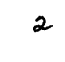

In [21]:
# At program start, load the model.
classify_digit = cntk.Function.load('mnist.cmf')

# To apply model, just call it.
image_input = X_test_mn[8345]        # (pick a random test digit for illustration)
scores = classify_digit(image_input) # call the model function with the input data
image_class = scores.argmax()        # find the highest-scoring class

# And that's it. Let's have a peek at the result
print('Recognized as:', image_class)
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(image_input, cmap="gray_r")

Models can be deployed directly from programs written in other programming languages for which bindings exist.
Please see the following example programs for an example similar to the Python one above:

 * C++: `Examples/Evaluation/CNTKLibraryCPPEvalCPUOnlyExamples/CNTKLibraryCPPEvalCPUOnlyExamples.cpp`
 * C#: `Examples/Evaluation/CNTKLibraryCSEvalCPUOnlyExamples/CNTKLibraryCSEvalExamples.cs`

To deploy a model from your own web service, load and invoke the model in the same way.

To deploy a model via an Azure web service, follow this tutorial: `Examples/Evaluation/CNTKAzureTutorial01`

## Conclusion

This tutorial provided an overview of the five main tasks of creating and using a deep neural network with CNTK.

We first examined CNTK's Functional programming and its tensor/sequence-based data model.
Then we considered the possible ways of feeding data to CNTK, including directly from RAM,
through CNTK's data-reading infrastructure (`MinibatchSource`), and spoon-feeding through a custom minibatch loop.
We then took a look at CNTK's advanced training options, including distributed training, logging to TensorBoard, checkpointing, CV-based training control, and final model evaluation.
Lastly, we briefly looked into model deployment.

We hope this guided your have you a good starting point for your own ventures with CNTK. Please enjoy!